# EARS (Ecological Acoustic Recorder) Data Analysis

This notebook provides a complete, modular solution for reading and analyzing EARS binary data files from Gulf of Mexico underwater acoustic recordings.

## Features
- **Binary file reader**: Parses the proprietary EARS format (.130, .190, etc.)
- **Timestamp extraction**: Decodes embedded timestamps from file headers
- **Modular plotting functions**: Waveform, spectrogram, and overview plots
- **Scientific best practices**: Uses NumPy and SciPy for efficient signal processing

## Dependencies
- `numpy`: Numerical array operations
- `matplotlib`: Plotting and visualization  
- `scipy`: Signal processing (spectrograms)
- `struct`, `datetime`, `pathlib`: Standard library for binary parsing and file handling

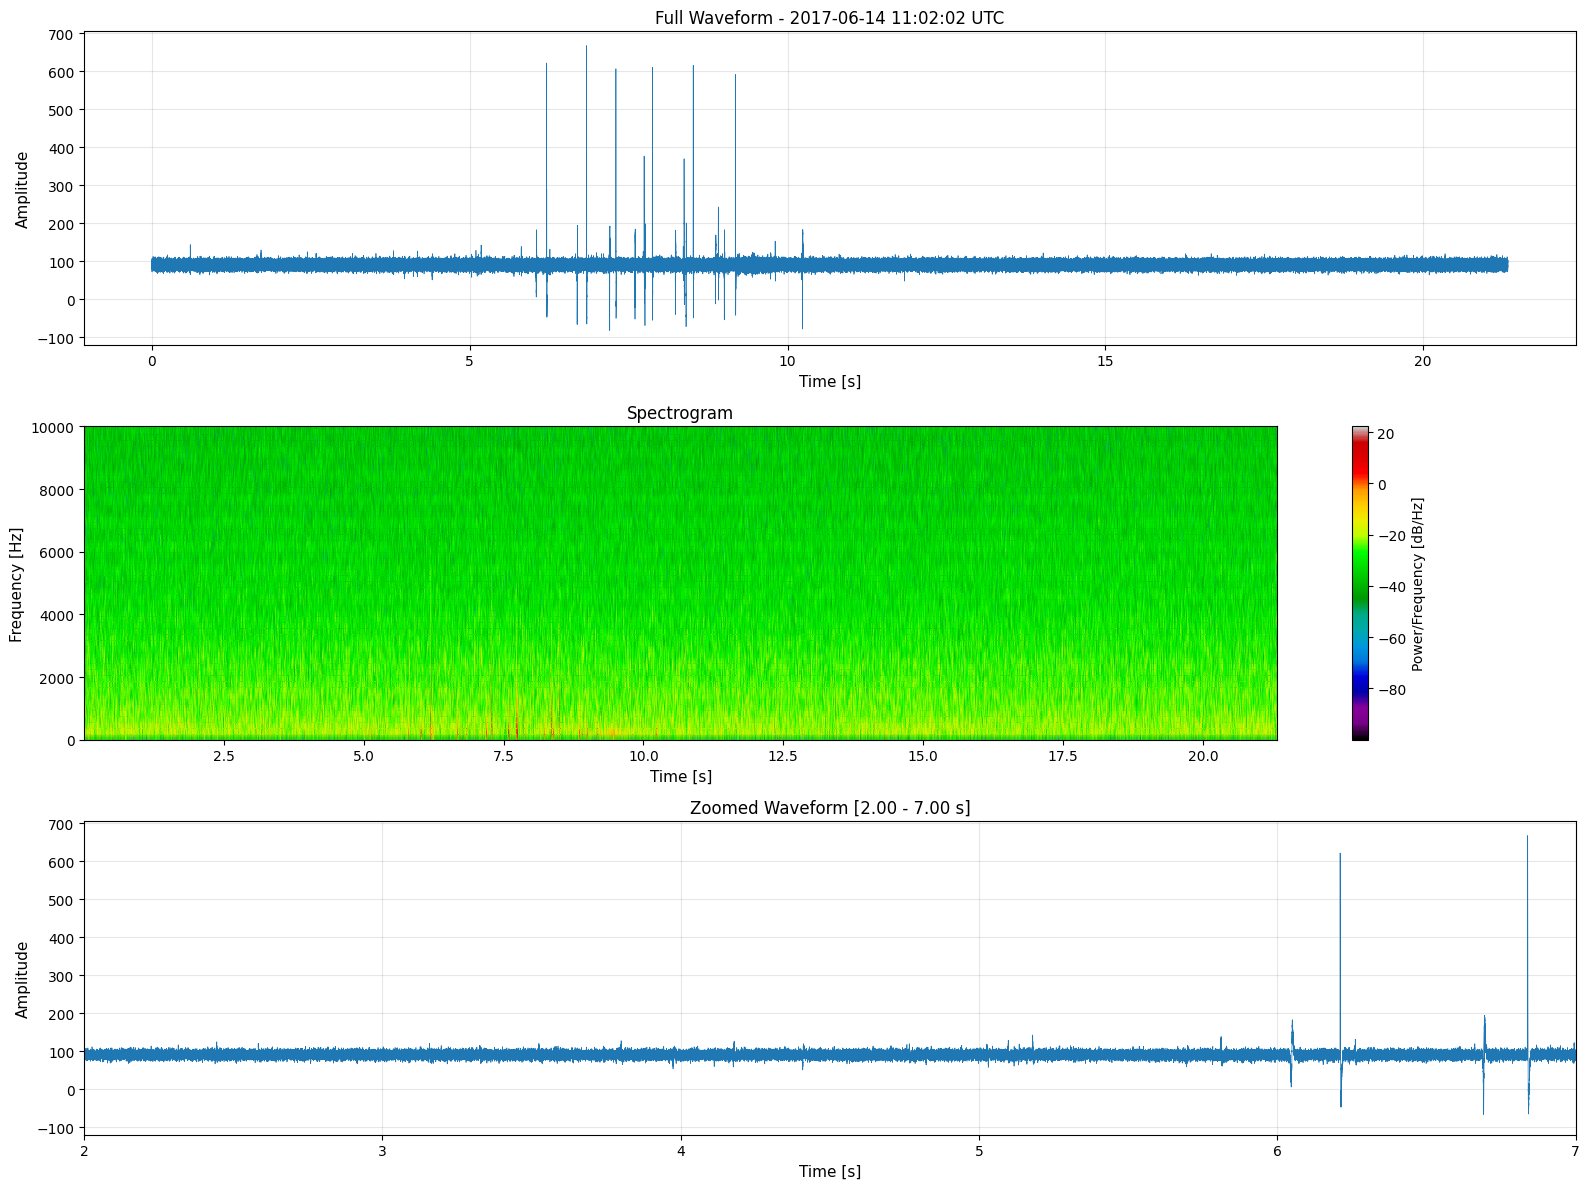

In [9]:
# Plot overview of the .130 file
plot_overview(ears_data_130, fmax=10000, xlim_zoom=(2, 7))

In [8]:
# Read the .130 file from the fourier_examples folder
sample_file_130 = Path('fourier_examples/data/7164403B.130')
ears_data_130 = read_ears_file(sample_file_130, normalize=False)

# Display file information
print(f"File: {sample_file_130}")
print(f"Recording start: {ears_data_130['time_start']}")
print(f"Recording end: {ears_data_130['time_end']}")
print(f"Duration: {ears_data_130['duration']:.2f} seconds")
print(f"Number of samples: {ears_data_130['n_samples']:,}")
print(f"Sampling rate: {ears_data_130['fs']:,} Hz")

File: fourier_examples/data/7164403B.130
Recording start: 2017-06-14 11:02:02.037500
Recording end: 2017-06-14 11:02:23.370833
Duration: 21.33 seconds
Number of samples: 4,096,000
Sampling rate: 192,000 Hz


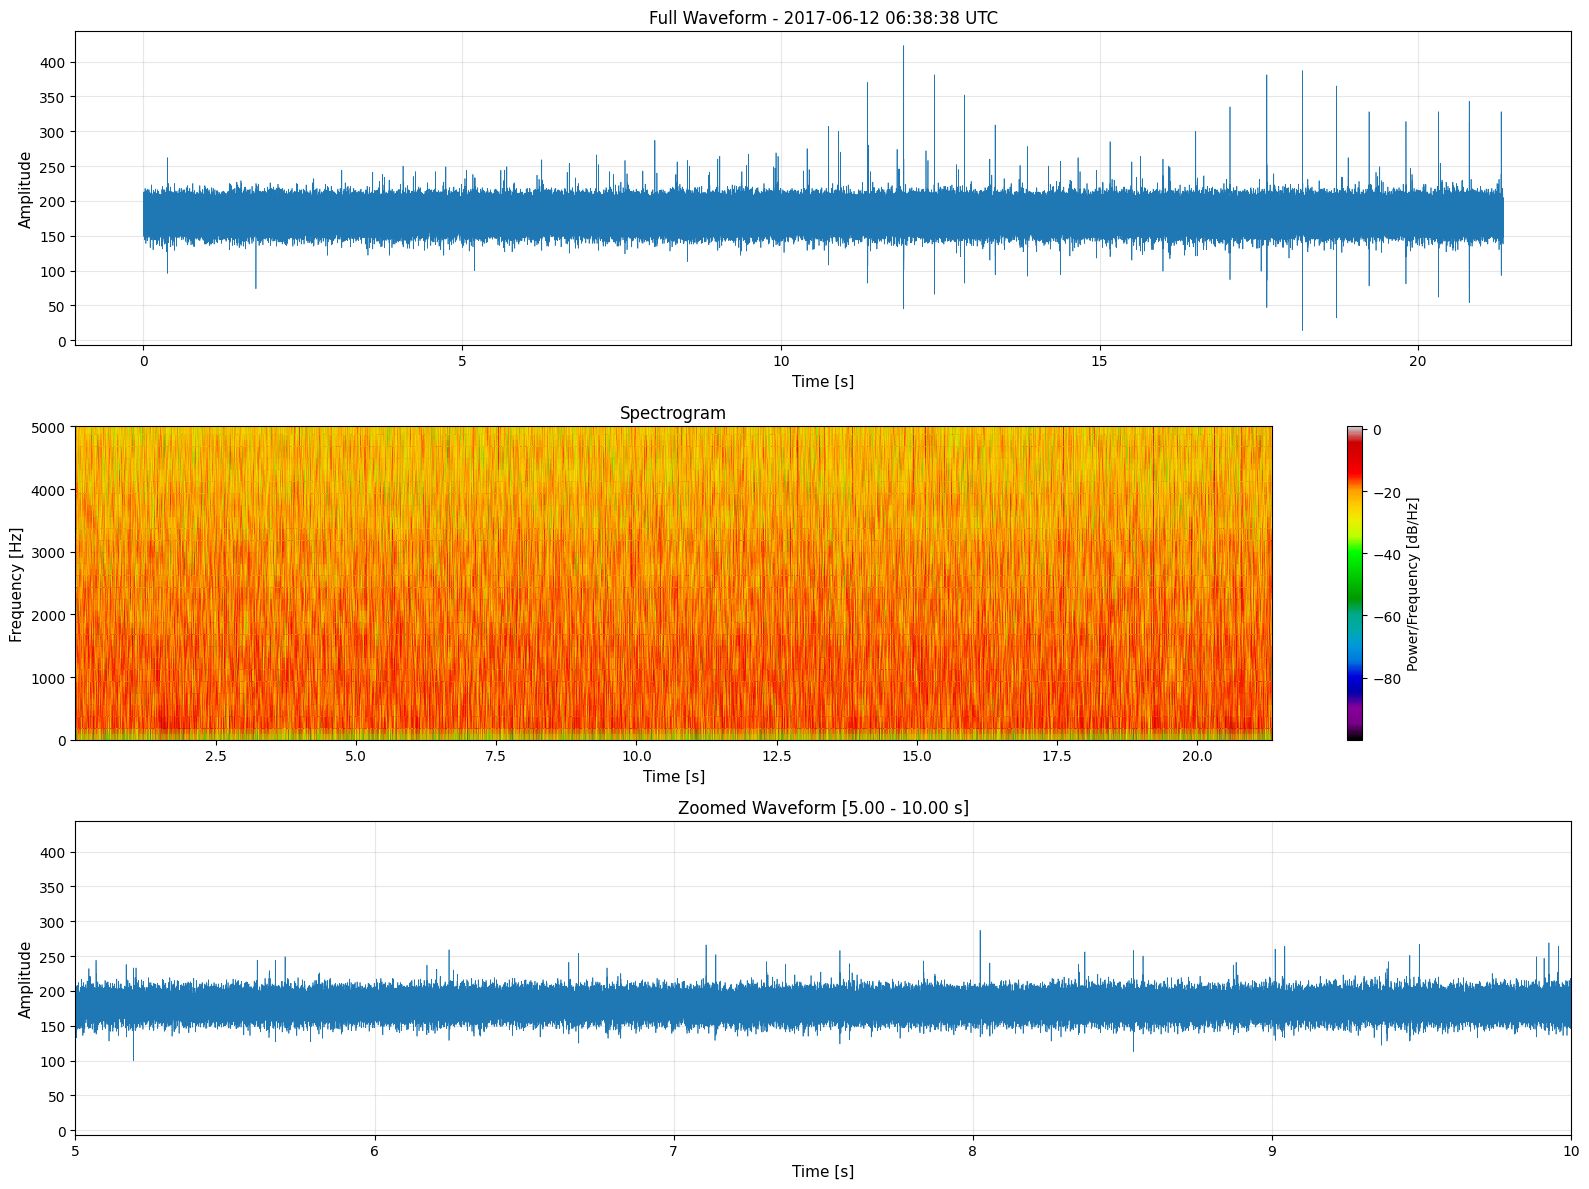

In [7]:
# Create comprehensive overview plot
plot_overview(ears_data_190, fmax=5000, xlim_zoom=(5, 10))

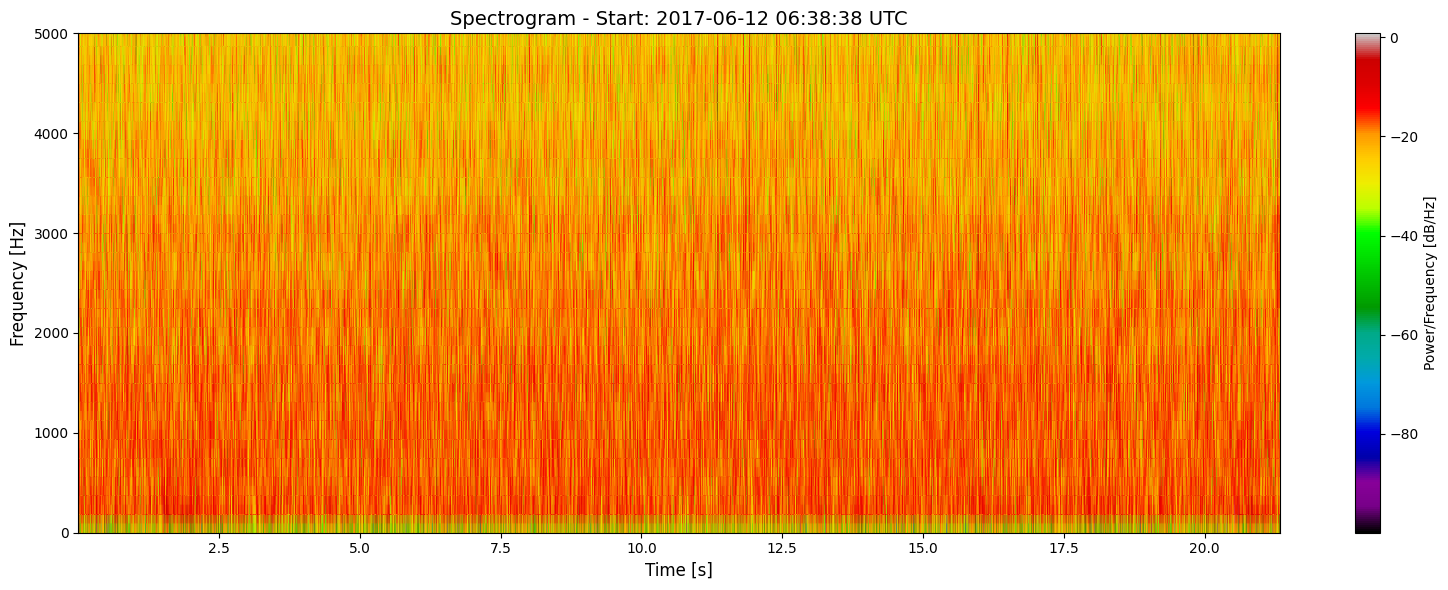

In [6]:
# Plot spectrogram (limiting to 5 kHz to see biological sounds)
plot_spectrogram(ears_data_190, fmax=5000)

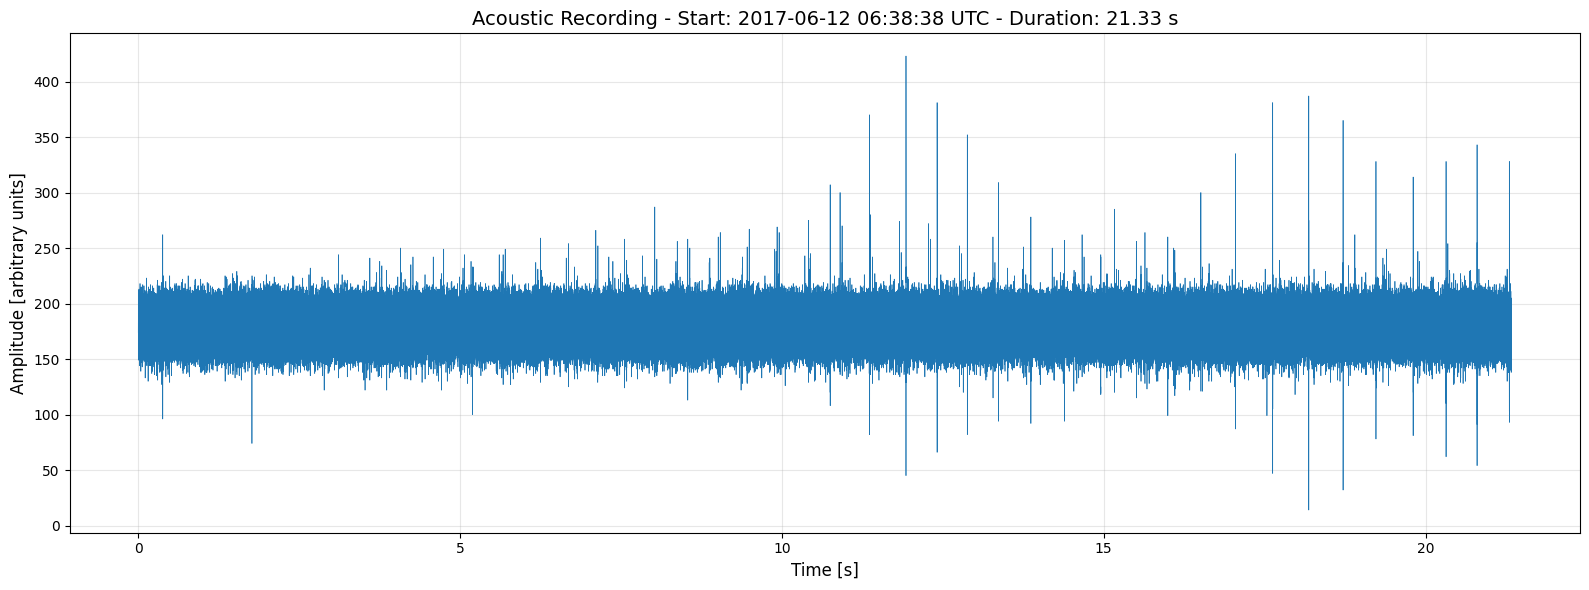

In [5]:
# Plot waveform
plot_waveform(ears_data_190)

In [4]:
# Read the .190 file from the sample_data folder
sample_file_190 = Path('unophysics/sample_data/71621DC7.190')
ears_data_190 = read_ears_file(sample_file_190, normalize=False)

# Display file information
print(f"File: {sample_file_190}")
print(f"Recording start: {ears_data_190['time_start']}")
print(f"Recording end: {ears_data_190['time_end']}")
print(f"Duration: {ears_data_190['duration']:.2f} seconds")
print(f"Number of samples: {ears_data_190['n_samples']:,}")
print(f"Sampling rate: {ears_data_190['fs']:,} Hz")

File: unophysics/sample_data/71621DC7.190
Recording start: 2017-06-12 06:38:38.348219
Recording end: 2017-06-12 06:38:59.681552
Duration: 21.33 seconds
Number of samples: 4,096,000
Sampling rate: 192,000 Hz


## Example: Read and Plot Sample Data Files

In [3]:
def plot_waveform(ears_data, xlim=None, figsize=(16, 6)):
    """
    Plot the acoustic waveform.
    
    Parameters
    ----------
    ears_data : dict
        Dictionary returned by read_ears_file()
    xlim : tuple, optional
        Time limits (start, end) in seconds
    figsize : tuple, optional
        Figure size (width, height)
    """
    data = ears_data['data']
    fs = ears_data['fs']
    time_start = ears_data['time_start']
    duration = ears_data['duration']
    
    # Create time array
    time = np.linspace(0, duration, len(data))
    
    # Create plot
    plt.figure(figsize=figsize)
    plt.plot(time, data, linewidth=0.5)
    plt.xlabel('Time [s]', fontsize=12)
    plt.ylabel('Amplitude [arbitrary units]', fontsize=12)
    plt.title(f'Acoustic Recording - Start: {time_start.strftime("%Y-%m-%d %H:%M:%S")} UTC - Duration: {duration:.2f} s',
              fontsize=14)
    plt.grid(True, alpha=0.3)
    
    if xlim is not None:
        plt.xlim(xlim)
    
    plt.tight_layout()
    plt.show()


def plot_spectrogram(ears_data, fmax=None, nperseg=1024, noverlap=512, 
                     figsize=(16, 6), cmap='nipy_spectral', vmin=None, vmax=None):
    """
    Plot a spectrogram of the acoustic data.
    
    Parameters
    ----------
    ears_data : dict
        Dictionary returned by read_ears_file()
    fmax : float, optional
        Maximum frequency to display (Hz)
    nperseg : int, optional
        Length of each segment for FFT
    noverlap : int, optional
        Number of points to overlap between segments
    figsize : tuple, optional
        Figure size (width, height)
    cmap : str, optional
        Colormap name
    vmin, vmax : float, optional
        Min and max values for color scale (in dB)
    """
    data = ears_data['data']
    fs = ears_data['fs']
    time_start = ears_data['time_start']
    
    # Compute spectrogram
    f, t, Sxx = signal.spectrogram(data, fs=fs, nperseg=nperseg, 
                                   noverlap=noverlap)
    
    # Convert to dB
    Sxx_dB = 10 * np.log10(np.abs(Sxx) + 1e-10)
    
    # Create plot
    plt.figure(figsize=figsize)
    plt.pcolormesh(t, f, Sxx_dB, shading='gouraud', cmap=cmap, 
                   vmin=vmin, vmax=vmax)
    plt.colorbar(label='Power/Frequency [dB/Hz]')
    plt.xlabel('Time [s]', fontsize=12)
    plt.ylabel('Frequency [Hz]', fontsize=12)
    plt.title(f'Spectrogram - Start: {time_start.strftime("%Y-%m-%d %H:%M:%S")} UTC',
              fontsize=14)
    
    if fmax is not None:
        plt.ylim([0, fmax])
    
    plt.tight_layout()
    plt.show()


def plot_overview(ears_data, fmax=None, xlim_zoom=None, figsize=(16, 12)):
    """
    Create a multi-panel overview plot with waveform and spectrogram.
    
    Parameters
    ----------
    ears_data : dict
        Dictionary returned by read_ears_file()
    fmax : float, optional
        Maximum frequency to display (Hz)
    xlim_zoom : tuple, optional
        Time limits for zoomed waveform (start, end) in seconds
    figsize : tuple, optional
        Figure size (width, height)
    """
    data = ears_data['data']
    fs = ears_data['fs']
    time_start = ears_data['time_start']
    duration = ears_data['duration']
    
    # Create time array
    time = np.linspace(0, duration, len(data))
    
    # Compute spectrogram
    f, t, Sxx = signal.spectrogram(data, fs=fs, nperseg=1024, noverlap=512)
    Sxx_dB = 10 * np.log10(np.abs(Sxx) + 1e-10)
    
    # Create subplots
    fig, axes = plt.subplots(3, 1, figsize=figsize)
    
    # Full waveform
    axes[0].plot(time, data, linewidth=0.5)
    axes[0].set_xlabel('Time [s]', fontsize=11)
    axes[0].set_ylabel('Amplitude', fontsize=11)
    axes[0].set_title(f'Full Waveform - {time_start.strftime("%Y-%m-%d %H:%M:%S")} UTC', 
                     fontsize=12)
    axes[0].grid(True, alpha=0.3)
    
    # Spectrogram
    im = axes[1].pcolormesh(t, f, Sxx_dB, shading='gouraud', cmap='nipy_spectral')
    axes[1].set_xlabel('Time [s]', fontsize=11)
    axes[1].set_ylabel('Frequency [Hz]', fontsize=11)
    axes[1].set_title('Spectrogram', fontsize=12)
    if fmax is not None:
        axes[1].set_ylim([0, fmax])
    plt.colorbar(im, ax=axes[1], label='Power/Frequency [dB/Hz]')
    
    # Zoomed waveform
    axes[2].plot(time, data, linewidth=0.5)
    axes[2].set_xlabel('Time [s]', fontsize=11)
    axes[2].set_ylabel('Amplitude', fontsize=11)
    if xlim_zoom is not None:
        axes[2].set_xlim(xlim_zoom)
        axes[2].set_title(f'Zoomed Waveform [{xlim_zoom[0]:.2f} - {xlim_zoom[1]:.2f} s]', 
                         fontsize=12)
    else:
        axes[2].set_title('Waveform (adjust xlim_zoom parameter to zoom)', fontsize=12)
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Plotting Functions

In [2]:
def read_ears_file(filepath, normalize=False):
    """
    Read an EARS binary data file.
    
    Parameters
    ----------
    filepath : str or Path
        Path to the EARS data file (.130, .190, etc.)
    normalize : bool, optional
        If True, normalize data to [-1, 1] range
    
    Returns
    -------
    dict
        Dictionary containing:
        - 'data': numpy array of acoustic samples
        - 'fs': sampling rate (Hz)
        - 'time_start': datetime of recording start
        - 'time_end': datetime of recording end
        - 'timestamps': list of timestamps from headers
        - 'duration': duration in seconds
    """
    # Constants
    RECORD_SIZE = 512
    HEADER_SIZE = 12
    SAMPLES_PER_RECORD = 250
    FS = 192000  # Sampling rate in Hz
    FS_TIME = 32000  # Timestamp sampling rate
    
    # Determine epoch based on filename
    filename = Path(filepath).name
    if filename[0] == '7':
        epoch = datetime.datetime(2015, 10, 27)
    else:
        epoch = datetime.datetime(2000, 1, 1)
    
    # Read binary file
    with open(filepath, 'rb') as f:
        raw_data = f.read()
    
    # Parse records
    data = []
    headers = []
    timestamps = []
    n_records = len(raw_data) // RECORD_SIZE
    
    for i in range(n_records):
        offset = RECORD_SIZE * i
        
        # Extract header
        header = raw_data[offset:offset + HEADER_SIZE]
        
        # Extract data (250 16-bit signed integers, big-endian)
        samples = struct.unpack_from('>250h', raw_data, 
                                     offset=offset + HEADER_SIZE)
        data.extend(samples)
        
        # Parse timestamp from header (only when it changes)
        if i == 0 or header != headers[-1]:
            headers.append(header)
            # Unpack timestamp bytes (6 bytes starting at byte 6)
            s = struct.unpack('6x6B', header)
            timestamp_seconds = (
                ((s[0] - 14) / 16) * 2**40 + 
                s[1] * 2**32 + 
                s[2] * 2**24 +
                s[3] * 2**16 + 
                s[4] * 2**8 + 
                s[5]
            ) / FS_TIME
            timestamp = epoch + datetime.timedelta(seconds=timestamp_seconds)
            timestamps.append(timestamp)
    
    # Convert to numpy array
    data = np.array(data, dtype=np.float64)
    
    # Normalize if requested
    if normalize:
        data -= np.mean(data)
        data /= np.max(np.abs(data))
    
    # Calculate timing information
    time_start = timestamps[0]
    duration = len(data) / FS
    time_end = time_start + datetime.timedelta(seconds=duration)
    
    return {
        'data': data,
        'fs': FS,
        'time_start': time_start,
        'time_end': time_end,
        'timestamps': timestamps,
        'duration': duration,
        'n_samples': len(data)
    }

## EARS File Format Specifications
- **Record size**: 512 bytes per record
- **Header size**: 12 bytes per record
- **Data per record**: 250 samples (16-bit signed integers, big-endian)
- **Sampling rate**: 192,000 Hz
- **Timestamp sampling rate**: 32,000 Hz
- **Epoch**: Files starting with '7' use epoch 2015-10-27; others use 2000-01-01

In [1]:
import struct
import datetime
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Configure matplotlib for inline plotting
%matplotlib inline